Running Policy Iteration


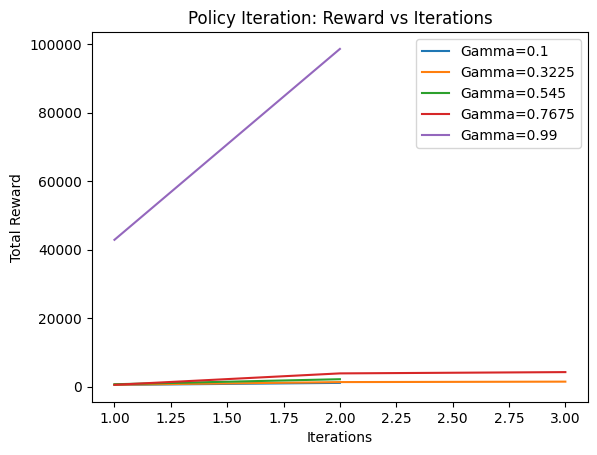

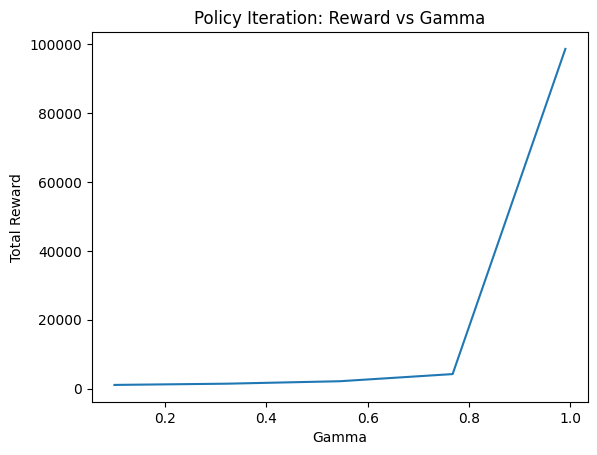

Best Policy: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 1

KeyboardInterrupt: 

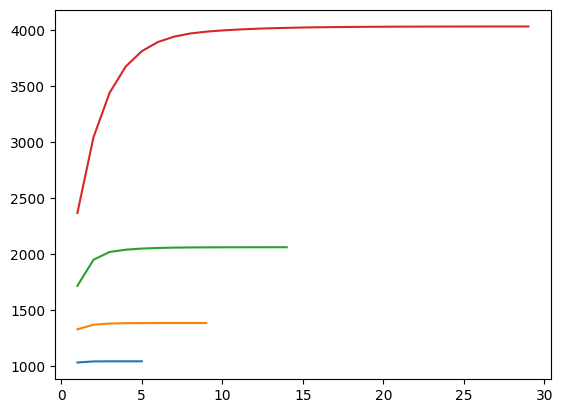

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random

class HotterColder(gym.Env):
    def __init__(self):
        self.range = 1500  # +/- the value number can be between
        self.bounds = 3000  # Action space bounds
        self.action_space = spaces.Box(
            low=np.array([-self.bounds]).astype(np.float32),
            high=np.array([self.bounds]).astype(np.float32),
        )
        self.observation_space = spaces.Discrete(1000)  # Increased number of states
        self.number = 0
        self.guess_count = 0
        self.guess_max = 500
        self.observation = 0
        self.seed()  # Set the random seed for reproducibility
        self.reset()

    def seed(self, seed=None):
        return [903967749]

    def step(self, action):
        if isinstance(action, (int, float)):
            action = np.array([action])
        elif isinstance(action, list):
            action = np.array(action)
        assert self.action_space.contains(action)
        distance = abs(action - self.number)
        if distance < 100:
            self.observation = 1  # Very close
        elif distance < 500:
            self.observation = 2  # Close
        elif distance < 1000:
            self.observation = 3  # Far
        else:
            self.observation = 4  # Very far
        reward = ((min(action, self.number) + self.bounds) / (max(action, self.number) + self.bounds)) ** 2
        self.guess_count += 1
        done = self.guess_count >= self.guess_max
        return (self.observation, reward[0], done, {"number": self.number, "guesses": self.guess_count})

    def reset(self):
        self.number = np.random.uniform(-self.range, self.range)
        self.guess_count = 0
        self.observation = 0
        return self.observation

# Discretize the action space
num_actions = 31
actions = np.linspace(-3000, 3000, num_actions)

# Policy Iteration
def policy_iteration(env, gamma_values):
    num_states = 1000  # Updated number of states
    policies = []
    total_rewards = []
    env.reset()

    for gamma in gamma_values:
        # Initialize random policy and value function
        policy = np.random.choice(num_actions, size=num_states)
        V = np.zeros(num_states)

        is_policy_stable = False
        iteration = 0
        rewards = []

        while not is_policy_stable:
            # Policy evaluation
            delta = float('inf')
            while delta > 1e-4:
                delta = 0
                for s in range(num_states):
                    v = V[s]
                    action = np.array([actions[policy[s]]]).astype(np.float32)  # Cast action to the required format
                    next_state, reward, done, _ = env.step(action)
                    V[s] = reward + gamma * V[next_state]
                    delta = max(delta, abs(v - V[s]))

            # Policy improvement
            is_policy_stable = True
            for s in range(num_states):
                old_action = policy[s]
                action_values = []
                for a in range(num_actions):
                    action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                    next_state, reward, done, _ = env.step(action)
                    action_values.append(reward + gamma * V[next_state])
                best_action = np.argmax(action_values)
                if old_action != best_action:
                    is_policy_stable = False
                policy[s] = best_action

            iteration += 1
            rewards.append(np.sum(V))

        policies.append(policy)
        total_rewards.append(rewards[-1])

        # Plot Reward vs Iterations for each gamma
        plt.plot(range(1, len(rewards) + 1), rewards, label=f'Gamma={gamma}')

    plt.xlabel('Iterations')
    plt.ylabel('Total Reward')
    plt.title('Policy Iteration: Reward vs Iterations')
    plt.legend()
    plt.savefig("images/hc" + "Policy Iteration: Reward vs Iterations.png")
    plt.show()

    # Plot Reward vs Gamma
    plt.plot(gamma_values, total_rewards)
    plt.xlabel('Gamma')
    plt.ylabel('Total Reward')
    plt.title('Policy Iteration: Reward vs Gamma')
    plt.savefig("images/hc" + "Policy Iteration: Reward vs Gamma'.png")
    plt.show()

    print("Best Policy:", policies[-1])


# Value Iteration
def value_iteration(env, gamma_values):
    num_states = 1000  # Updated number of states
    total_rewards = []
    env.reset()
    

    for gamma in gamma_values:
        V = np.zeros(num_states)
        rewards = []

        delta = float('inf')
        iteration = 0

        while delta > 1e-4:
            delta = 0
            for s in range(num_states):
                v = V[s]
                action_values = []
                for a in range(num_actions):
                    action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                    next_state, reward, done, _ = env.step(action)
                    action_values.append(reward + gamma * V[next_state])
                V[s] = max(action_values)
                delta = max(delta, abs(v - V[s]))
            iteration += 1
            rewards.append(np.sum(V))

        total_rewards.append(rewards[-1])

        # Plot Reward vs Iterations for each gamma
        plt.plot(range(1, len(rewards) + 1), rewards, label=f'Gamma={gamma}')

    plt.xlabel('Iterations')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Iterations')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Iterations.png")
    plt.legend()
    plt.show()

    # Plot Reward vs Gamma
    plt.plot(gamma_values, total_rewards)
    plt.xlabel('Gamma')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Gamma')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Gamma.png")
    plt.show()




# Q-Learning
def q_learning(env, alpha, gamma_values, epsilon, episodes):
    num_states = env.observation_space.n
    num_actions = 31
    actions = np.linspace(-3000, 3000, num_actions)

    mean_times_vs_iterations = []
    mean_rewards_vs_iterations = []
    mean_rewards_vs_gamma = []

    for gamma in gamma_values:
        q_table = np.zeros((num_states, num_actions))
        rewards_per_episode = []
        steps_per_episode = []

        for episode in range(episodes):
            state = env.reset()
            done = False
            episode_reward = 0
            iteration = 0

            while not done:
                # Select action using epsilon-greedy policy
                if np.random.uniform(0, 1) < epsilon:
                    action_idx = np.random.choice(num_actions)
                else:
                    action_idx = np.argmax(q_table[state])

                action_value = np.array([actions[action_idx]]).astype(np.float32)
                action_value = np.clip(action_value, -env.bounds, env.bounds)

                # Take a step in the environment
                next_state, reward, done, _ = env.step(action_value)

                # Update Q-table
                q_table[state, action_idx] += alpha * (
                    reward + gamma * np.max(q_table[next_state]) - q_table[state, action_idx]
                )

                state = next_state
                episode_reward += reward
                iteration += 1

            rewards_per_episode.append(episode_reward)
            steps_per_episode.append(iteration)

        mean_times_vs_iterations.append(np.mean(steps_per_episode))
        mean_rewards_vs_iterations.append(np.mean(rewards_per_episode))
        mean_rewards_vs_gamma.append(np.mean(rewards_per_episode))

        # Plot Mean Time vs Iterations
        plt.plot(range(1, episodes + 1), steps_per_episode, label=f'Gamma={gamma}')

    plt.xlabel('Episodes')
    plt.ylabel('Mean Time (Steps per Episode)')
    plt.title('Q-Learning: Mean Time vs Iterations')
    plt.savefig("images/hc" + "Q-Learning: Mean Time vs Iterations.png")
    plt.legend()
    plt.show()

    # Plot Mean Reward vs Iterations
    plt.plot(range(1, episodes + 1), rewards_per_episode)
    plt.xlabel('Episodes')
    plt.ylabel('Mean Reward')
    plt.title('Q-Learning: Mean Reward vs Iterations')
    plt.savefig("images/hc" + "Q-Learning: Mean Reward vs Iterations.png")
    plt.show()

    # Plot Mean Reward vs Gamma
    plt.plot(gamma_values, mean_rewards_vs_gamma)
    plt.xlabel('Gamma')
    plt.ylabel('Mean Reward')
    plt.title('Q-Learning: Mean Reward vs Gamma')
    plt.savefig("images/hc" + "Q-Learning: Mean Reward vs Gamma.png")
    plt.show()

    # Extract Best Policy
    best_policy = [np.argmax(q_table[s]) for s in range(num_states)]
    print("Best Policy (action indices):", best_policy)



# Running Experiments
gamma_values = np.linspace(0.1, 0.99, 5)
env = HotterColder()

print("Running Policy Iteration")
policy_iteration(env, gamma_values)

print("Running Value Iteration")
value_iteration(env, gamma_values)

print("Running Q-Learning")
q_learning(env, alpha=0.1, gamma_values=gamma_values, epsilon=0.1, episodes=500)


Running Policy Iteration


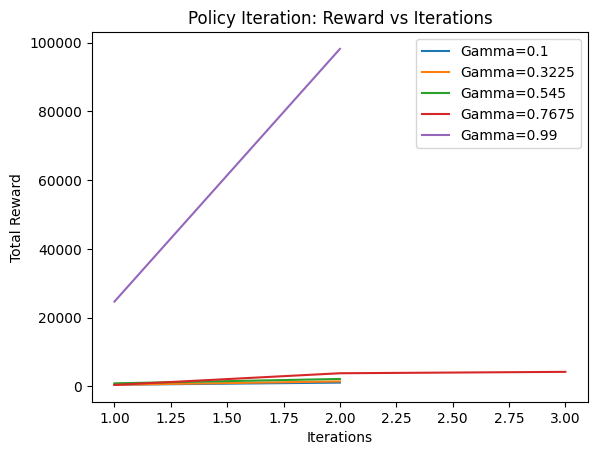

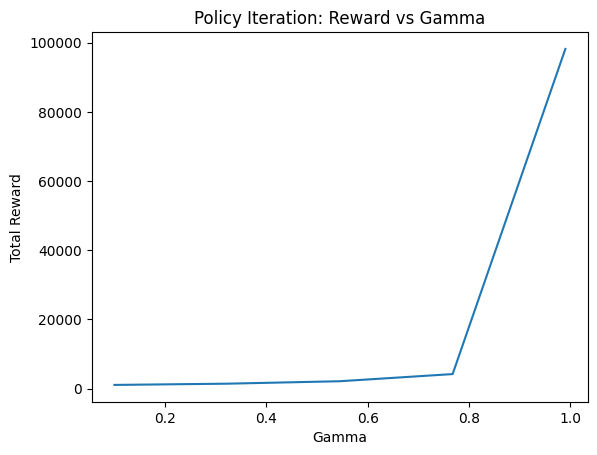

Best Policy: [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 1

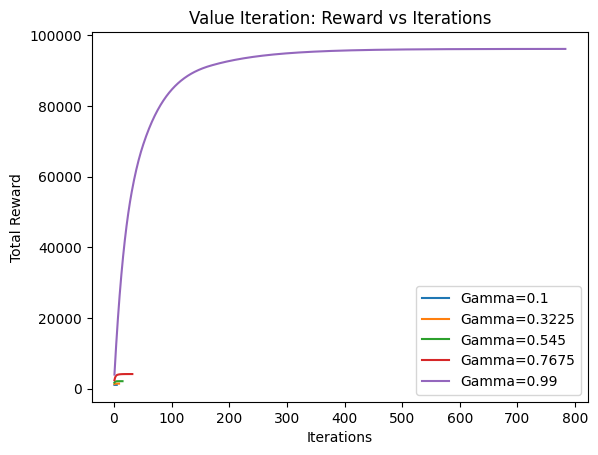

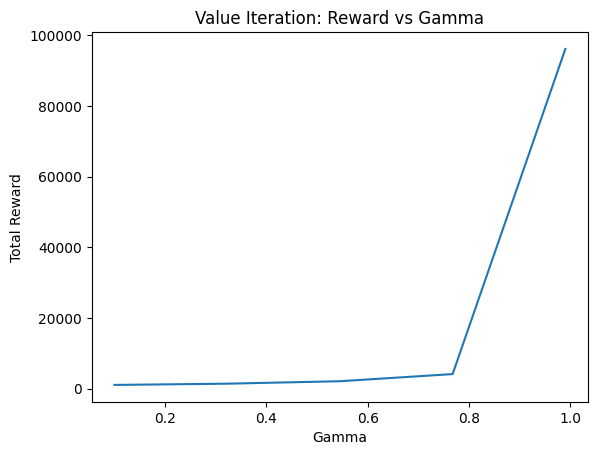

Best Policy for Gamma=0.1: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

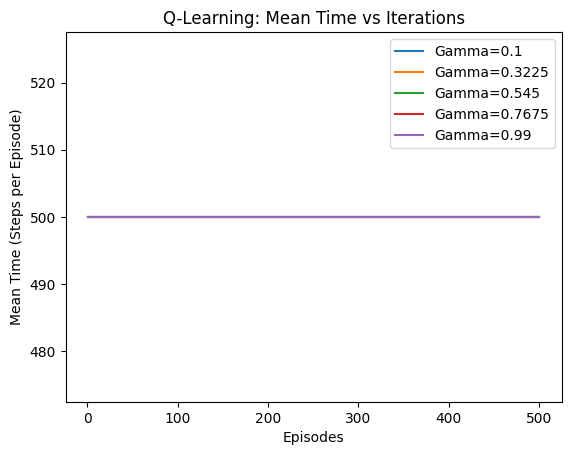

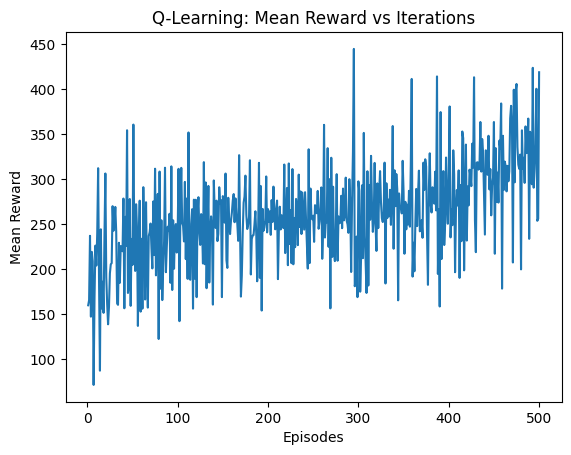

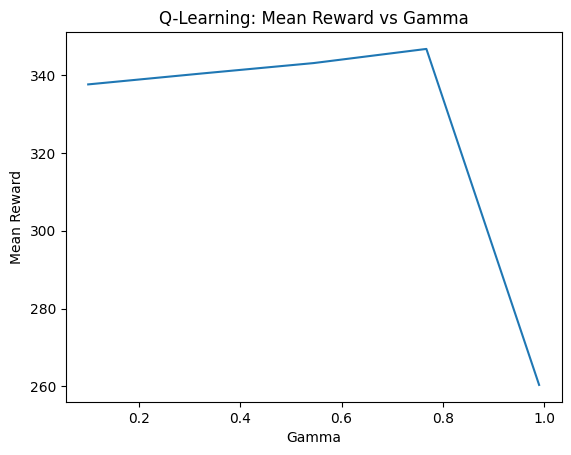

Best Policy (action indices): [0, 25, 20, 22, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [73]:
def value_iteration(env, gamma_values):
    num_states = 1000  # Updated number of states
    total_rewards = []
    best_policies = []  # Store the best policy for each gamma
    env.reset()
    
    for gamma in gamma_values:
        V = np.zeros(num_states)
        rewards = []

        delta = float('inf')
        iteration = 0

        while delta > 1e-4:
            delta = 0
            for s in range(num_states):
                v = V[s]
                action_values = []
                for a in range(num_actions):
                    action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                    next_state, reward, done, _ = env.step(action)
                    action_values.append(reward + gamma * V[next_state])
                V[s] = max(action_values)
                delta = max(delta, abs(v - V[s]))
            iteration += 1
            rewards.append(np.sum(V))

        # Extract best policy from value function
        best_policy = []
        for s in range(num_states):
            action_values = []
            for a in range(num_actions):
                action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                next_state, reward, done, _ = env.step(action)
                action_values.append(reward + gamma * V[next_state])
            best_action = np.argmax(action_values)
            best_policy.append(best_action)
        best_policies.append(best_policy)

        total_rewards.append(rewards[-1])

        # Plot Reward vs Iterations for each gamma
        plt.plot(range(1, len(rewards) + 1), rewards, label=f'Gamma={gamma}')

    plt.xlabel('Iterations')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Iterations')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Iterations.png")
    plt.legend()
    plt.show()

    # Plot Reward vs Gamma
    plt.plot(gamma_values, total_rewards)
    plt.xlabel('Gamma')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Gamma')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Gamma.png")
    plt.show()

    # Print Best Policy for each gamma
    for i, gamma in enumerate(gamma_values):
        print(f"Best Policy for Gamma={gamma}: {best_policies[i]}")

# Running Experiments
gamma_values = np.linspace(0.1, 0.99, 5)
env = HotterColder()

print("Running Policy Iteration")
policy_iteration(env, gamma_values)

print("Running Value Iteration")
value_iteration(env, gamma_values)

print("Running Q-Learning")
q_learning(env, alpha=0.1, gamma_values=gamma_values, epsilon=0.1, episodes=500)


Running Policy Iteration
Time taken for Policy Iteration: 0.04 seconds
Running Value Iteration


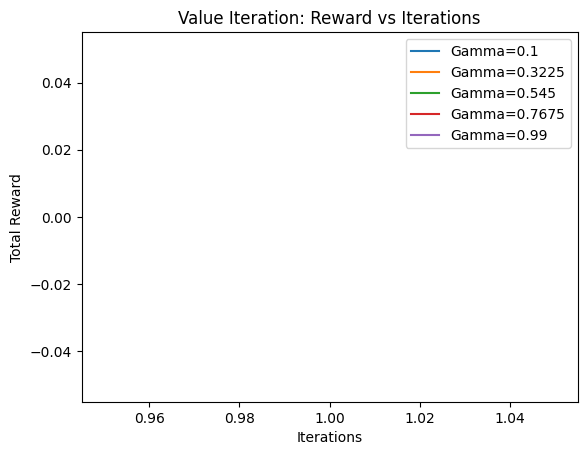

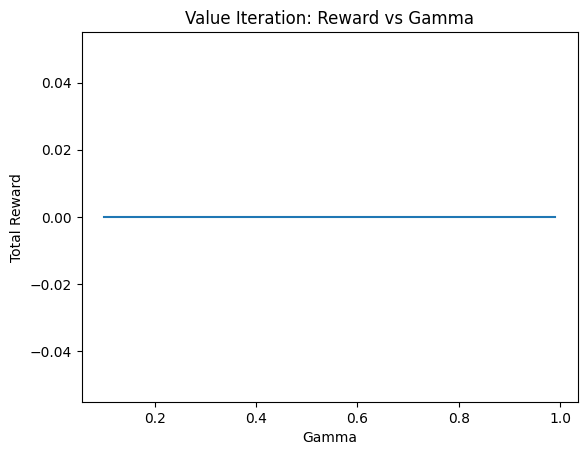

Best Policy for Gamma=0.1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

KeyboardInterrupt: 

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import time

class HotterColder:
    def reset(self):
        # Add your environment reset logic here
        pass
    
    def step(self, action):
        # Add your environment step logic here
        # Return next_state, reward, done, info
        return 0, 0, False, {}

def value_iteration(env, gamma_values):
    num_states = 1000  # Updated number of states
    total_rewards = []
    best_policies = []  # Store the best policy for each gamma
    env.reset()
    
    start_time = time.time()  # Record the start time

    for gamma in gamma_values:
        V = np.zeros(num_states)
        rewards = []

        delta = float('inf')
        iteration = 0

        while delta > 1e-4:
            delta = 0
            for s in range(num_states):
                v = V[s]
                action_values = []
                for a in range(num_actions):
                    action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                    next_state, reward, done, _ = env.step(action)
                    action_values.append(reward + gamma * V[next_state])
                V[s] = max(action_values)
                delta = max(delta, abs(v - V[s]))
            iteration += 1
            rewards.append(np.sum(V))

        # Extract best policy from value function
        best_policy = []
        for s in range(num_states):
            action_values = []
            for a in range(num_actions):
                action = np.array([actions[a]]).astype(np.float32)  # Cast action to the required format
                next_state, reward, done, _ = env.step(action)
                action_values.append(reward + gamma * V[next_state])
            best_action = np.argmax(action_values)
            best_policy.append(best_action)
        best_policies.append(best_policy)

        total_rewards.append(rewards[-1])

        # Plot Reward vs Iterations for each gamma
        plt.plot(range(1, len(rewards) + 1), rewards, label=f'Gamma={gamma}')

    plt.xlabel('Iterations')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Iterations')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Iterations.png")
    plt.legend()
    plt.show()

    # Plot Reward vs Gamma
    plt.plot(gamma_values, total_rewards)
    plt.xlabel('Gamma')
    plt.ylabel('Total Reward')
    plt.title('Value Iteration: Reward vs Gamma')
    plt.savefig("images/hc" + "Value Iteration: Reward vs Gamma.png")
    plt.show()

    # Print Best Policy for each gamma
    for i, gamma in enumerate(gamma_values):
        print(f"Best Policy for Gamma={gamma}: {best_policies[i]}")
    
    end_time = time.time()  # Record the end time
    print(f"Time taken for Value Iteration: {end_time - start_time:.2f} seconds")

def policy_iteration(env, gamma_values):
    start_time = time.time()  # Record the start time
    num_states = 1000  # Updated number of states
    num_actions = 4  # Assuming there are 4 possible actions
    best_policies = []  # Store the best policy for each gamma
    
    for gamma in gamma_values:
        policy = np.zeros(num_states, dtype=int)
        V = np.zeros(num_states)
        policy_stable = False
        
        while not policy_stable:
            # Policy Evaluation
            delta = float('inf')
            while delta > 1e-4:
                delta = 0
                for s in range(num_states):
                    v = V[s]
                    action = np.array([actions[policy[s]]]).astype(np.float32)
                    next_state, reward, done, _ = env.step(action)
                    V[s] = reward + gamma * V[next_state]
                    delta = max(delta, abs(v - V[s]))
            
            # Policy Improvement
            policy_stable = True
            for s in range(num_states):
                old_action = policy[s]
                action_values = []
                for a in range(num_actions):
                    action = np.array([actions[a]]).astype(np.float32)
                    next_state, reward, done, _ = env.step(action)
                    action_values.append(reward + gamma * V[next_state])
                best_action = np.argmax(action_values)
                policy[s] = best_action
                if old_action != best_action:
                    policy_stable = False
        
        best_policies.append(policy)
    
    end_time = time.time()  # Record the end time
    print(f"Time taken for Policy Iteration: {end_time - start_time:.2f} seconds")

def q_learning(env, alpha, gamma_values, epsilon, episodes):
    start_time = time.time()  # Record the start time
    num_states = 1000  # Updated number of states
    num_actions = 4  # Assuming there are 4 possible actions
    
    for gamma in gamma_values:
        Q = np.zeros((num_states, num_actions))
        
        for episode in range(episodes):
            state = env.reset()
            done = False
            
            while not done:
                if np.random.rand() < epsilon:
                    action = np.random.randint(num_actions)
                else:
                    action = np.argmax(Q[state])
                
                next_state, reward, done, _ = env.step(action)
                best_next_action = np.argmax(Q[next_state])
                Q[state, action] = Q[state, action] + alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])
                state = next_state
    
    end_time = time.time()  # Record the end time
    print(f"Time taken for Q-Learning: {end_time - start_time:.2f} seconds")

# Running Experiments
gamma_values = np.linspace(0.1, 0.99, 5)
env = HotterColder()

print("Running Policy Iteration")
policy_iteration(env, gamma_values)

print("Running Value Iteration")
value_iteration(env, gamma_values)

print("Running Q-Learning")
q_learning(env, alpha=0.1, gamma_values=gamma_values, epsilon=0.1, episodes=500)
